In [1]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
import numpy as np
# import pylab
from datetime import datetime

# import os
# import math
# import random
import pandas as pd
# import itertools
from scipy.io import loadmat
# from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset
# import glob3 as glob

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


In [3]:

torch.cuda.is_available()

True

In [4]:
import torchvision.models as models
import torch.nn as nn
resnet = models.resnet18()

In [5]:

model_name = "resnet"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 512

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [6]:
# #Rasnet18
# resnet.conv1 = nn.Conv2d(in_channels=40, out_channels=64, kernel_size=7,stride=2, padding=3, bias=False)
# resnet.fc = nn.Linear(2048, num_classes)

In [7]:
def train_model(model, dataloaders, criterion, optimizer, optimizer2, num_epochs=25, is_inception=False):
    since = time.time()
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    lr_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 1e10
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=0, eps=1e-08)
    scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=0, eps=1e-08)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            epoch_samples = 0
            confusion_matrix = torch.zeros(3, 3)
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.type(torch.FloatTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                if epoch < 5:
                    optimizer.zero_grad()
                else:
                    optimizer2.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                     # statistics
                    epoch_samples += inputs.size(0)
                    # statistics
                    for t, p in zip(labels.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1

                    running_corrects += torch.sum(preds == labels.data)


                confusionMat = np.asarray(confusion_matrix)
                sumconfusion = np.sum(confusionMat,axis = 1).T

                summat = np.tile(sumconfusion,(3,1)).T
                # print(test)
                percentconfusion = np.divide(confusionMat,summat)
                epoch_acc_balanced = np.sum(np.diagonal(percentconfusion))/3

                # statistics
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
        

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_loss = epoch_loss
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
            
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print()
        if epoch < 5:
            scheduler.step(epoch_loss)
        else:
            scheduler2.step(epoch_loss)
#         if epoch >= 6  and val_loss_history [-1] >= val_loss_history [-2] >= val_loss_history [-3] >= val_loss_history[-4]>=val_loss_history[-5]>=val_loss_history[-6]:
#             break
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,train_acc_history,train_loss_history, val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7,stride=2, padding=3, bias=False)
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 1
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:

x = torch.randn(4, 1, 80,80)

# Let's print it
outputs = model_ft(x)
print(outputs)

model_ft

tensor([[-0.8910,  0.3786, -1.1148],
        [ 0.4104,  0.5001, -0.7018],
        [ 0.9363,  0.1092, -1.3188],
        [ 0.5070,  0.6617, -0.5546]], grad_fn=<AddmmBackward>)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
Datadir = "H:\\CellLineClassification\\2DProjections\\2DProjections"

In [12]:
import os

def datapreparation(Datadir):
    trainpath = []
    trainlabel = []
    fpath = []
    traindir = Datadir + "\\HEK"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('HEK data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(0)

    fpath = []
    traindir = Datadir + "\\HELA"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('HELA data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i]) 
        trainlabel.append(1)

    fpath = []
    traindir = Datadir + "\\MCF7"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('MCF7 data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(2)
    return trainpath,trainlabel

In [13]:
X, Y = datapreparation(Datadir)

HEK data: 3191
HELA data: 3315
MCF7 data: 3764


In [14]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
trainindex = {}
testindex = {}
i = 0
for train_index, test_index in kfold.split(X,Y):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    trainindex[i] = train_index
    testindex[i] = test_index
    i = i + 1
#fold - 0
# print(trainindex[1])
# indices = trainindex[1]
trainpath =[X[i] for i in trainindex[1]]
testpath =[X[i] for i in testindex[1]]

Train Index:  [    0     1     2 ... 10267 10268 10269] 

Test Index:  [    3     5     6 ... 10262 10263 10264]
Train Index:  [    3     5     6 ... 10266 10267 10269] 

Test Index:  [    0     1     2 ... 10258 10259 10268]
Train Index:  [    0     1     2 ... 10267 10268 10269] 

Test Index:  [    9    10    11 ... 10249 10253 10265]
Train Index:  [    0     1     2 ... 10266 10268 10269] 

Test Index:  [    7    13    17 ... 10252 10257 10267]
Train Index:  [    0     1     2 ... 10265 10267 10268] 

Test Index:  [   20    21    27 ... 10255 10266 10269]


In [20]:
from skimage import io
import skimage.transform
import scipy
class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data = io.imread(self.paths[index])
#         reshape = skimage.transform.resize(data,(224,224,40))
#         x = torch.from_numpy(reshape.astype(np.float32))
        x = torch.from_numpy(data.astype(np.float32)/65535)
        x = x.unsqueeze(dim = 0)
#         x = np.transpose(x,(2,0,1))
#         x = np.transpose(np.array(data['Data']),(2,0,1))
        if 'HEK' in self.paths[index]:
            label = int(0)
        elif 'HELA' in self.paths[index]:
            label = int(1)
        elif 'MCF7' in self.paths[index]:
            label = int(2)
        if self.transforms:
            x= self.transforms(x)
        return x,label
    
    def __len__(self):
        return len(self.paths)

In [21]:
#actual training
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['HEK','HELA','MCF7']
image_datasets['train'].__getitem__(0)[0].shape
[ImgTensor,ImgLabel] = image_datasets['train'].__getitem__(0)
print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
image_datasets['train'].__getitem__(0)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)

training data volume:  8216
validation data volume:  2054
Cell Label:  HEK
image tensor shape:  torch.Size([1, 80, 80])
image tensor dtype:  torch.float32
image shape:  (80, 80)


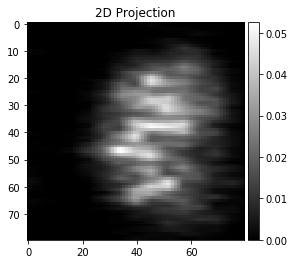

In [22]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.transpose(ImgTensor.numpy(), (1,2,0))

def DisplayImage(img,LimMin,LimMax):  
    if img.shape[2]>1:
        for depth in range (0,10):
            plt.subplot(2,5,depth+1)
            plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')
            # plt.colorbar()
            plt.title('z = '+ str(depth))
            if depth==9:
                plt.subplot(2,5,depth+1)
                plt.title('z = '+ str(depth))
                ax = plt.gca()
                fig4 = plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
    else:
        fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
        plt.title('2D Projection')
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
DisplayImage(image,image.min(),image.max())

In [23]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
        transforms.Resize(input_size),
#         transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(input_size),
        transforms.ToTensor(),
#         transforms.Normalize([0.00351, 0.00351, 0.00351], [0.009389, 0.009389, 0.009389])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
        transforms.ToTensor(),
#         transforms.Normalize([0.00351, 0.00351, 0.00351], [0.009389, 0.009389, 0.009389])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 0 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 5e-06
train Loss: 1.0246 Acc: 0.4766
train Bal. Acc: 0.4807
val Loss: 1.1026 Acc: 0.3116
val Bal. Acc: 0.3338
saving best model
Total time: 0:00:18.079807
Epoch time: 0m 18s

Epoch 1/99
----------
LR 5e-06
train Loss: 0.9439 Acc: 0.5459
train Bal. Acc: 0.5555
val Loss: 1.0927 Acc: 0.3398
val Bal. Acc: 0.3617
saving best model
Total time: 0:00:28.832541
Epoch time: 0m 29s

Epoch 2/99
----------
LR 5e-06
train Loss: 0.9058 Acc: 0.5755
train Bal. Acc: 0.5807
val Loss: 1.0093 Acc: 0.4776
val Bal. Acc: 0.4992
saving best model
Total time: 0:00:39.991552
Epoch time: 0m 40s

Epoch 3/99
----------
LR 5e-06
train Loss: 0.8723 Acc: 0.6044
train Bal. Acc: 0.6074
val Loss: 0.9661 Acc: 0.5239
val Bal. Acc: 0.5427
saving best model
Total time: 0:00:51.213750
Epoch time: 0m 51s

Epoch 4/99
----------
LR 5e-06
train Loss: 0.8407 Acc: 0.6319
train Bal. Acc: 0.6338
val Loss: 0.8933 Acc: 0.5964
val Bal. Acc: 0.6024
saving best mo

train Loss: 0.1569 Acc: 0.9693
train Bal. Acc: 0.9692
val Loss: 0.4800 Acc: 0.7994
val Bal. Acc: 0.8014
Total time: 0:08:11.428792
Epoch time: 8m 11s

Epoch 43/99
----------
LR 5e-05
train Loss: 0.1535 Acc: 0.9676
train Bal. Acc: 0.9675
val Loss: 0.4770 Acc: 0.8072
val Bal. Acc: 0.8091
saving best model
Total time: 0:08:22.113492
Epoch time: 8m 22s

Epoch 44/99
----------
LR 5e-05
train Loss: 0.1412 Acc: 0.9740
train Bal. Acc: 0.9739
val Loss: 0.5025 Acc: 0.7970
val Bal. Acc: 0.8020
Total time: 0:08:33.652863
Epoch time: 8m 34s

Epoch 45/99
----------
LR 5e-05
train Loss: 0.1380 Acc: 0.9736
train Bal. Acc: 0.9731
val Loss: 0.4852 Acc: 0.8043
val Bal. Acc: 0.8051
Total time: 0:08:44.520473
Epoch time: 8m 45s

Epoch 46/99
----------
LR 5e-05
train Loss: 0.1270 Acc: 0.9797
train Bal. Acc: 0.9795
val Loss: 0.4848 Acc: 0.8014
val Bal. Acc: 0.8028
Total time: 0:08:55.293638
Epoch time: 8m 55s

Epoch 47/99
----------
LR 5e-05
train Loss: 0.1225 Acc: 0.9792
train Bal. Acc: 0.9792
val Loss: 0.4

val Loss: 0.5856 Acc: 0.7960
val Bal. Acc: 0.8000
Total time: 0:15:59.020924
Epoch time: 15m 59s

Epoch    79: reducing learning rate of group 0 to 7.8125e-07.
Epoch 85/99
----------
LR 7.8125e-07
train Loss: 0.0194 Acc: 0.9996
train Bal. Acc: 0.9997
val Loss: 0.5883 Acc: 0.7936
val Bal. Acc: 0.7972
Total time: 0:16:09.820680
Epoch time: 16m 10s

Epoch 86/99
----------
LR 7.8125e-07
train Loss: 0.0247 Acc: 0.9982
train Bal. Acc: 0.9982
val Loss: 0.6089 Acc: 0.7941
val Bal. Acc: 0.7939
Total time: 0:16:20.467447
Epoch time: 16m 20s

Epoch 87/99
----------
LR 7.8125e-07
train Loss: 0.0213 Acc: 0.9993
train Bal. Acc: 0.9993
val Loss: 0.5870 Acc: 0.7975
val Bal. Acc: 0.8005
Total time: 0:16:31.545972
Epoch time: 16m 32s

Epoch 88/99
----------
LR 7.8125e-07
train Loss: 0.0189 Acc: 0.9999
train Bal. Acc: 0.9999
val Loss: 0.5953 Acc: 0.7921
val Bal. Acc: 0.7968
Total time: 0:16:42.251594
Epoch time: 16m 42s

Epoch 89/99
----------
LR 7.8125e-07
train Loss: 0.0238 Acc: 0.9973
train Bal. Acc: 

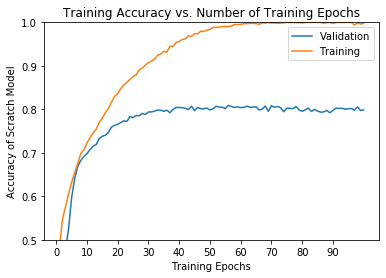

100


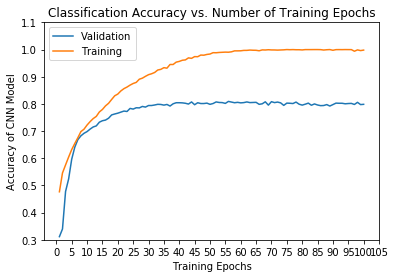

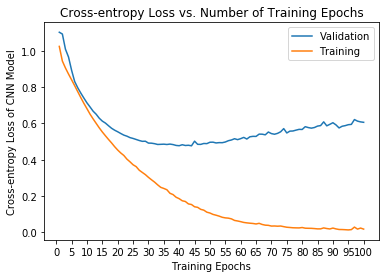

tensor([[594.,  21.,  24.],
        [ 43., 481., 139.],
        [ 30., 135., 587.]])
[667. 637. 750.]
[[0.92957747 0.03286385 0.03755869]
 [0.06485672 0.7254902  0.2096531 ]
 [0.03989362 0.17952128 0.7805851 ]]



Fold- 1 : Initializing Datasets and Dataloaders...


C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type "

Epoch 0/99
----------
LR 5e-06
train Loss: 1.1599 Acc: 0.3832
train Bal. Acc: 0.3994
val Loss: 1.1575 Acc: 0.3286
val Bal. Acc: 0.3519
saving best model
Total time: 0:00:11.096170
Epoch time: 0m 11s

Epoch 1/99
----------
LR 5e-06
train Loss: 1.0460 Acc: 0.4662
train Bal. Acc: 0.4906
val Loss: 1.2073 Acc: 0.3213
val Bal. Acc: 0.3444
Total time: 0:00:22.427243
Epoch time: 0m 22s

Epoch 2/99
----------
LR 5e-06
train Loss: 0.9796 Acc: 0.4814
train Bal. Acc: 0.5064
val Loss: 1.1518 Acc: 0.3705
val Bal. Acc: 0.3951
saving best model
Total time: 0:00:33.270472
Epoch time: 0m 33s

Epoch 3/99
----------
LR 5e-06
train Loss: 0.9290 Acc: 0.5292
train Bal. Acc: 0.5504
val Loss: 1.0371 Acc: 0.4630
val Bal. Acc: 0.4867
saving best model
Total time: 0:00:44.724948
Epoch time: 0m 45s

Epoch 4/99
----------
LR 5e-06
train Loss: 0.8915 Acc: 0.5731
train Bal. Acc: 0.5881
val Loss: 0.9266 Acc: 0.5424
val Bal. Acc: 0.5553
saving best model
Total time: 0:00:55.963474
Epoch time: 0m 56s

Epoch 5/99
-------

train Loss: 0.1951 Acc: 0.9572
train Bal. Acc: 0.9571
val Loss: 0.5368 Acc: 0.7760
val Bal. Acc: 0.7778
saving best model
Total time: 0:08:01.611724
Epoch time: 8m 2s

Epoch 43/99
----------
LR 5e-05
train Loss: 0.1859 Acc: 0.9620
train Bal. Acc: 0.9621
val Loss: 0.5394 Acc: 0.7741
val Bal. Acc: 0.7767
Total time: 0:08:12.529302
Epoch time: 8m 13s

Epoch 44/99
----------
LR 5e-05
train Loss: 0.1766 Acc: 0.9643
train Bal. Acc: 0.9644
val Loss: 0.5370 Acc: 0.7741
val Bal. Acc: 0.7755
Total time: 0:08:23.541204
Epoch time: 8m 24s

Epoch 45/99
----------
LR 5e-05
train Loss: 0.1684 Acc: 0.9679
train Bal. Acc: 0.9679
val Loss: 0.5444 Acc: 0.7795
val Bal. Acc: 0.7830
saving best model
Total time: 0:08:34.841096
Epoch time: 8m 35s

Epoch 46/99
----------
LR 5e-05
train Loss: 0.1555 Acc: 0.9716
train Bal. Acc: 0.9715
val Loss: 0.5403 Acc: 0.7741
val Bal. Acc: 0.7745
Total time: 0:08:46.244044
Epoch time: 8m 46s

Epoch 47/99
----------
LR 5e-05
train Loss: 0.1504 Acc: 0.9719
train Bal. Acc: 0.9

train Loss: 0.0266 Acc: 0.9993
train Bal. Acc: 0.9993
val Loss: 0.6503 Acc: 0.7804
val Bal. Acc: 0.7841
Total time: 0:15:44.361775
Epoch time: 15m 44s

Epoch 85/99
----------
LR 7.8125e-07
train Loss: 0.0302 Acc: 0.9982
train Bal. Acc: 0.9983
val Loss: 0.6793 Acc: 0.7751
val Bal. Acc: 0.7817
Total time: 0:15:55.069403
Epoch time: 15m 55s

Epoch 86/99
----------
LR 7.8125e-07
train Loss: 0.0559 Acc: 0.9865
train Bal. Acc: 0.9862
val Loss: 0.6788 Acc: 0.7595
val Bal. Acc: 0.7584
Total time: 0:16:06.123054
Epoch time: 16m 6s

Epoch 87/99
----------
LR 7.8125e-07
train Loss: 0.0303 Acc: 0.9972
train Bal. Acc: 0.9972
val Loss: 0.6450 Acc: 0.7731
val Bal. Acc: 0.7748
Total time: 0:16:17.168720
Epoch time: 16m 17s

Epoch 88/99
----------
LR 7.8125e-07
train Loss: 0.0255 Acc: 0.9988
train Bal. Acc: 0.9988
val Loss: 0.6573 Acc: 0.7741
val Bal. Acc: 0.7783
Total time: 0:16:27.941650
Epoch time: 16m 28s

Epoch 89/99
----------
LR 7.8125e-07
train Loss: 0.0244 Acc: 0.9989
train Bal. Acc: 0.9989
va

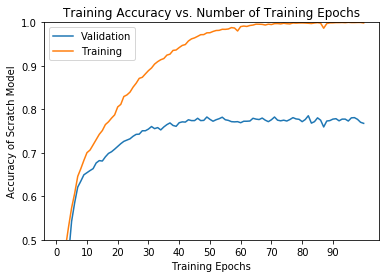

100


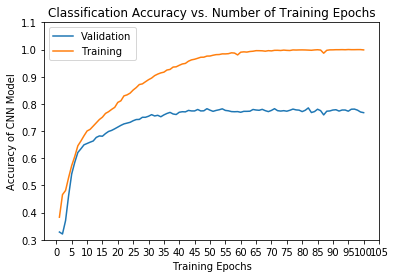

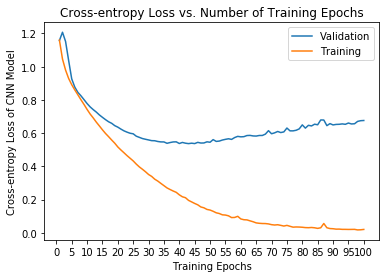

tensor([[588.,  32.,  18.],
        [ 57., 472., 134.],
        [ 51., 149., 553.]])
[696. 653. 705.]
[[0.9216301  0.05015674 0.02821317]
 [0.08597285 0.71191555 0.20211162]
 [0.06772909 0.19787517 0.73439574]]



Fold- 2 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 5e-06
train Loss: 1.0677 Acc: 0.4339
train Bal. Acc: 0.4591
val Loss: 1.1260 Acc: 0.3106
val Bal. Acc: 0.3333
saving best model
Total time: 0:00:11.242387
Epoch time: 0m 11s

Epoch 1/99
----------
LR 5e-06
train Loss: 0.9799 Acc: 0.4966
train Bal. Acc: 0.5195
val Loss: 1.1193 Acc: 0.3247
val Bal. Acc: 0.3479
saving best model
Total time: 0:00:22.448416
Epoch time: 0m 22s

Epoch 2/99
----------
LR 5e-06
train Loss: 0.9290 Acc: 0.5529
train Bal. Acc: 0.5681
val Loss: 1.0510 Acc: 0.4245
val Bal. Acc: 0.4493
saving best model
Total time: 0:00:33.806230
Epoch time: 0m 34s

Epoch 3/99
----------
LR 5e-06
train Loss: 0.8889 Acc: 0.6004
train Bal. Acc: 0.6086
val Loss: 0.9742 Acc: 0.5355
val Bal. Acc: 0.5490


val Loss: 0.4936 Acc: 0.7950
val Bal. Acc: 0.7965
Total time: 0:07:35.971467
Epoch time: 7m 36s

Epoch 41/99
----------
LR 5e-05
train Loss: 0.1615 Acc: 0.9687
train Bal. Acc: 0.9683
val Loss: 0.4970 Acc: 0.7911
val Bal. Acc: 0.7921
Total time: 0:07:46.519078
Epoch time: 7m 47s

Epoch 42/99
----------
LR 5e-05
train Loss: 0.1543 Acc: 0.9690
train Bal. Acc: 0.9686
val Loss: 0.4991 Acc: 0.7892
val Bal. Acc: 0.7895
Total time: 0:07:57.096986
Epoch time: 7m 57s

Epoch 43/99
----------
LR 5e-05
train Loss: 0.1442 Acc: 0.9733
train Bal. Acc: 0.9731
val Loss: 0.5091 Acc: 0.7853
val Bal. Acc: 0.7845
Total time: 0:08:07.944583
Epoch time: 8m 8s

Epoch    38: reducing learning rate of group 0 to 2.5000e-05.
Epoch 44/99
----------
LR 2.5e-05
train Loss: 0.1354 Acc: 0.9785
train Bal. Acc: 0.9783
val Loss: 0.5006 Acc: 0.7955
val Bal. Acc: 0.7971
Total time: 0:08:18.445692
Epoch time: 8m 18s

Epoch 45/99
----------
LR 2.5e-05
train Loss: 0.1278 Acc: 0.9802
train Bal. Acc: 0.9800
val Loss: 0.5048 Acc

train Loss: 0.0214 Acc: 0.9995
train Bal. Acc: 0.9996
val Loss: 0.5970 Acc: 0.7892
val Bal. Acc: 0.7918
Total time: 0:15:07.922170
Epoch time: 15m 8s

Epoch 83/99
----------
LR 7.8125e-07
train Loss: 0.0222 Acc: 0.9994
train Bal. Acc: 0.9994
val Loss: 0.5970 Acc: 0.7887
val Bal. Acc: 0.7912
Total time: 0:15:18.474304
Epoch time: 15m 18s

Epoch 84/99
----------
LR 7.8125e-07
train Loss: 0.0214 Acc: 0.9999
train Bal. Acc: 0.9999
val Loss: 0.6027 Acc: 0.7941
val Bal. Acc: 0.7974
Total time: 0:15:29.389443
Epoch time: 15m 29s

Epoch 85/99
----------
LR 7.8125e-07
train Loss: 0.0222 Acc: 0.9989
train Bal. Acc: 0.9989
val Loss: 0.6004 Acc: 0.7931
val Bal. Acc: 0.7948
Total time: 0:15:40.044312
Epoch time: 15m 40s

Epoch    80: reducing learning rate of group 0 to 3.9063e-07.
Epoch 86/99
----------
LR 3.90625e-07
train Loss: 0.0203 Acc: 0.9999
train Bal. Acc: 0.9999
val Loss: 0.6032 Acc: 0.7892
val Bal. Acc: 0.7915
Total time: 0:15:50.821778
Epoch time: 15m 51s

Epoch 87/99
----------
LR 3.90

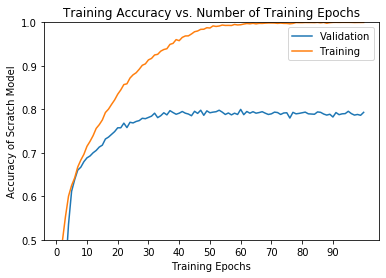

100


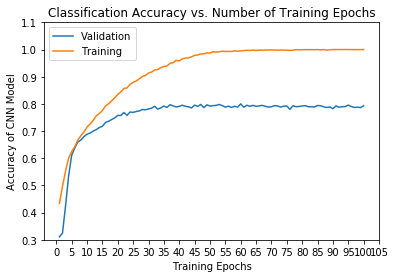

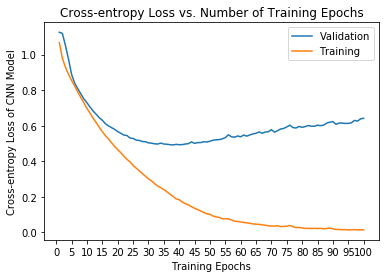

tensor([[588.,  23.,  27.],
        [ 51., 467., 145.],
        [ 34., 131., 588.]])
[673. 621. 760.]
[[0.9216301  0.03605016 0.04231975]
 [0.07692308 0.7043741  0.21870287]
 [0.04515272 0.17397079 0.7808765 ]]



Fold- 3 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 5e-06
train Loss: 1.0218 Acc: 0.4254
train Bal. Acc: 0.4372
val Loss: 1.1063 Acc: 0.3106
val Bal. Acc: 0.3333
saving best model
Total time: 0:00:10.681123
Epoch time: 0m 11s

Epoch 1/99
----------
LR 5e-06
train Loss: 0.9472 Acc: 0.5330
train Bal. Acc: 0.5480
val Loss: 1.1495 Acc: 0.3140
val Bal. Acc: 0.3367
saving best model
Total time: 0:00:21.674992
Epoch time: 0m 22s

Epoch 2/99
----------
LR 5e-06
train Loss: 0.9102 Acc: 0.5699
train Bal. Acc: 0.5791
val Loss: 1.0915 Acc: 0.3632
val Bal. Acc: 0.3874
saving best model
Total time: 0:00:32.680374
Epoch time: 0m 33s

Epoch 3/99
----------
LR 5e-06
train Loss: 0.8762 Acc: 0.6080
train Bal. Acc: 0.6122
val Loss: 1.0199 Acc: 0.4601
val Bal. Acc: 0.4770


train Loss: 0.1590 Acc: 0.9681
train Bal. Acc: 0.9681
val Loss: 0.5122 Acc: 0.7882
val Bal. Acc: 0.7893
saving best model
Total time: 0:07:20.483991
Epoch time: 7m 20s

Epoch 41/99
----------
LR 2.5e-05
train Loss: 0.1477 Acc: 0.9742
train Bal. Acc: 0.9743
val Loss: 0.5156 Acc: 0.7863
val Bal. Acc: 0.7866
Total time: 0:07:31.524173
Epoch time: 7m 32s

Epoch 42/99
----------
LR 2.5e-05
train Loss: 0.1390 Acc: 0.9754
train Bal. Acc: 0.9756
val Loss: 0.5156 Acc: 0.7887
val Bal. Acc: 0.7899
saving best model
Total time: 0:07:42.358977
Epoch time: 7m 42s

Epoch 43/99
----------
LR 2.5e-05
train Loss: 0.1305 Acc: 0.9791
train Bal. Acc: 0.9792
val Loss: 0.5161 Acc: 0.7868
val Bal. Acc: 0.7894
Total time: 0:07:52.972813
Epoch time: 7m 53s

Epoch 44/99
----------
LR 2.5e-05
train Loss: 0.1227 Acc: 0.9825
train Bal. Acc: 0.9826
val Loss: 0.5243 Acc: 0.7902
val Bal. Acc: 0.7906
saving best model
Total time: 0:08:03.953360
Epoch time: 8m 4s

Epoch 45/99
----------
LR 2.5e-05
train Loss: 0.1145 Acc

train Loss: 0.0185 Acc: 0.9998
train Bal. Acc: 0.9998
val Loss: 0.6170 Acc: 0.7877
val Bal. Acc: 0.7893
Total time: 0:14:54.986674
Epoch time: 14m 55s

Epoch 83/99
----------
LR 3.90625e-07
train Loss: 0.0176 Acc: 0.9995
train Bal. Acc: 0.9995
val Loss: 0.6188 Acc: 0.7907
val Bal. Acc: 0.7920
Total time: 0:15:05.477603
Epoch time: 15m 5s

Epoch 84/99
----------
LR 3.90625e-07
train Loss: 0.0156 Acc: 1.0000
train Bal. Acc: 1.0000
val Loss: 0.6175 Acc: 0.7931
val Bal. Acc: 0.7949
Total time: 0:15:16.404469
Epoch time: 15m 16s

Epoch 85/99
----------
LR 3.90625e-07
train Loss: 0.0166 Acc: 0.9996
train Bal. Acc: 0.9996
val Loss: 0.6240 Acc: 0.7863
val Bal. Acc: 0.7869
Total time: 0:15:27.255192
Epoch time: 15m 27s

Epoch 86/99
----------
LR 3.90625e-07
train Loss: 0.0173 Acc: 0.9998
train Bal. Acc: 0.9997
val Loss: 0.6237 Acc: 0.7858
val Bal. Acc: 0.7870
Total time: 0:15:38.010265
Epoch time: 15m 38s

Epoch 87/99
----------
LR 3.90625e-07
train Loss: 0.0188 Acc: 0.9995
train Bal. Acc: 0.99

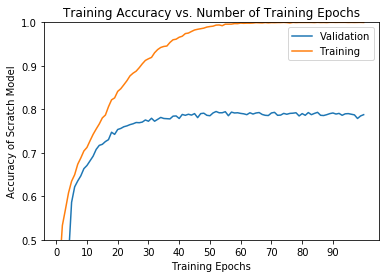

100


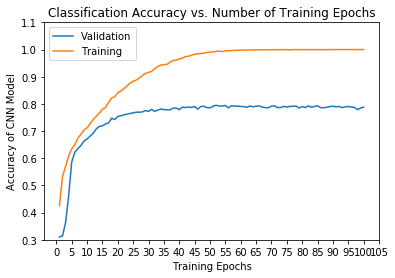

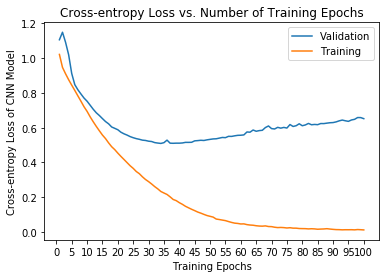

tensor([[576.,  32.,  30.],
        [ 50., 458., 155.],
        [ 26., 128., 599.]])
[652. 618. 784.]
[[0.9028213  0.05015674 0.04702194]
 [0.07541478 0.6907994  0.23378582]
 [0.03452855 0.16998672 0.7954847 ]]



Fold- 4 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 5e-06
train Loss: 1.0305 Acc: 0.4422
train Bal. Acc: 0.4408
val Loss: 1.0968 Acc: 0.3272
val Bal. Acc: 0.3253
saving best model
Total time: 0:00:10.651682
Epoch time: 0m 11s

Epoch 1/99
----------
LR 5e-06
train Loss: 0.9460 Acc: 0.5428
train Bal. Acc: 0.5505
val Loss: 1.1002 Acc: 0.3968
val Bal. Acc: 0.4067
saving best model
Total time: 0:00:21.094010
Epoch time: 0m 21s

Epoch 2/99
----------
LR 5e-06
train Loss: 0.9090 Acc: 0.5761
train Bal. Acc: 0.5802
val Loss: 1.0354 Acc: 0.4635
val Bal. Acc: 0.4715
saving best model
Total time: 0:00:31.572020
Epoch time: 0m 32s

Epoch 3/99
----------
LR 5e-06
train Loss: 0.8771 Acc: 0.6025
train Bal. Acc: 0.6043
val Loss: 0.9506 Acc: 0.5565
val Bal. Acc: 0.5584


val Loss: 0.5282 Acc: 0.7790
val Bal. Acc: 0.7799
Total time: 0:07:22.859689
Epoch time: 7m 23s

Epoch 41/99
----------
LR 5e-05
train Loss: 0.1715 Acc: 0.9662
train Bal. Acc: 0.9660
val Loss: 0.5252 Acc: 0.7921
val Bal. Acc: 0.7954
saving best model
Total time: 0:07:33.931126
Epoch time: 7m 34s

Epoch 42/99
----------
LR 5e-05
train Loss: 0.1664 Acc: 0.9674
train Bal. Acc: 0.9671
val Loss: 0.5247 Acc: 0.7941
val Bal. Acc: 0.7966
saving best model
Total time: 0:07:45.065236
Epoch time: 7m 45s

Epoch 43/99
----------
LR 5e-05
train Loss: 0.1541 Acc: 0.9726
train Bal. Acc: 0.9722
val Loss: 0.5292 Acc: 0.7877
val Bal. Acc: 0.7915
Total time: 0:07:56.009400
Epoch time: 7m 56s

Epoch 44/99
----------
LR 5e-05
train Loss: 0.1452 Acc: 0.9725
train Bal. Acc: 0.9721
val Loss: 0.5372 Acc: 0.7785
val Bal. Acc: 0.7783
Total time: 0:08:06.444452
Epoch time: 8m 6s

Epoch    39: reducing learning rate of group 0 to 2.5000e-05.
Epoch 45/99
----------
LR 2.5e-05
train Loss: 0.1392 Acc: 0.9749
train Bal

train Loss: 0.0236 Acc: 0.9996
train Bal. Acc: 0.9997
val Loss: 0.6229 Acc: 0.7916
val Bal. Acc: 0.7947
Total time: 0:14:58.720381
Epoch time: 14m 59s

Epoch 83/99
----------
LR 7.8125e-07
train Loss: 0.0238 Acc: 0.9998
train Bal. Acc: 0.9997
val Loss: 0.6411 Acc: 0.7858
val Bal. Acc: 0.7860
Total time: 0:15:09.570904
Epoch time: 15m 10s

Epoch 84/99
----------
LR 7.8125e-07
train Loss: 0.0220 Acc: 0.9999
train Bal. Acc: 0.9999
val Loss: 0.6346 Acc: 0.7921
val Bal. Acc: 0.7954
Total time: 0:15:20.672192
Epoch time: 15m 21s

Epoch 85/99
----------
LR 7.8125e-07
train Loss: 0.0210 Acc: 0.9998
train Bal. Acc: 0.9998
val Loss: 0.6313 Acc: 0.7882
val Bal. Acc: 0.7899
Total time: 0:15:31.678569
Epoch time: 15m 32s

Epoch 86/99
----------
LR 7.8125e-07
train Loss: 0.0202 Acc: 0.9996
train Bal. Acc: 0.9996
val Loss: 0.6653 Acc: 0.7833
val Bal. Acc: 0.7827
Total time: 0:15:42.843412
Epoch time: 15m 43s

Epoch    81: reducing learning rate of group 0 to 3.9063e-07.
Epoch 87/99
----------
LR 3.90

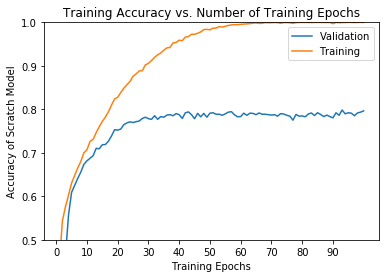

100


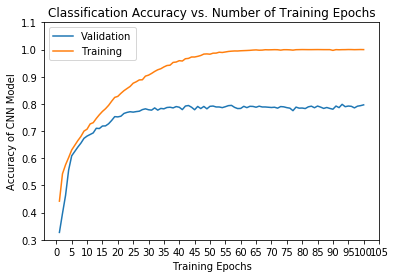

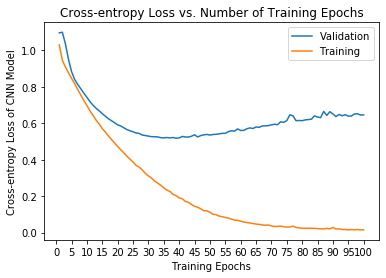

tensor([[586.,  29.,  23.],
        [ 45., 484., 134.],
        [ 22., 161., 570.]])
[653. 674. 727.]
[[0.9184953  0.04545455 0.03605016]
 [0.06787331 0.7300151  0.20211162]
 [0.02921647 0.21381143 0.75697213]]





In [24]:
# train model 20 times
for runs in range(0,5):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    trainpath =[X[i] for i in trainindex[runs]]
    testpath =[X[i] for i in testindex[runs]]
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 3
    loss_hist_train = []
    
    # Number of epochs to train for
    num_epochs = 100
    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()
    # Initialize the non-pretrained version of the model used for this run
    scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
    scratch_model = scratch_model.to(device)
#     scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.0005, momentum=0.9)
#     scratch_optimizer = optim.Adam(scratch_model.parameters(),lr=0.00001,betas = (0.9, 0.9999),eps=1e-08,weight_decay=0)
    scratch_optimizer = optim.Adam(scratch_model.parameters(),lr=5e-6,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
    scratch_optimizer2 = optim.Adam(scratch_model.parameters(),lr=5e-5,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
    scratch_criterion = nn.CrossEntropyLoss()
    model, scratch_hist_val,scratch_hist_train,loss_hist_train, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, scratch_optimizer2, num_epochs=num_epochs, is_inception=(model_name=="inception"))

    fname1 = "training_acc_"+str(runs)+".csv"
    np.savetxt(fname1,scratch_hist_train , delimiter=",")
    fname2 = "validation_acc_"+str(runs)+".csv"
    np.savetxt(fname2,scratch_hist_val , delimiter=",")
    fname13 = "training_Bacc_"+str(runs)+".csv"
    np.savetxt(fname13,train_Bacc_hist, delimiter=",")
    fname23 = "validation_Bacc_"+str(runs)+".csv"
    np.savetxt(fname23,val_Bacc_hist, delimiter=",")
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist , delimiter=",")
    
    shist = []
    shist1 = []

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Training Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of Scratch Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.5,1.))
    plt.xticks(np.arange(0, num_epochs, 10.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'.png'
    plt.savefig(fname3)
    plt.show()

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Classification Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of CNN Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.3,1.1))
    plt.xticks(np.arange(0, len(shist)+10, 5.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
    plt.savefig(fname3)
    plt.show()

    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Cross-entropy Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Cross-entropy Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    confusionMat = np.asarray(confusion_matrix)
    sumconfusion = np.sum(confusionMat,axis = 0)
    print(sumconfusion)

    import scipy
    sumconfusion = np.sum(confusionMat,axis = 1).T
    # print(np.tile(sumconfusion,(4,1)))
    summat = np.tile(sumconfusion,(3,1)).T
    # print(test)
    percentconfusion = np.divide(confusionMat,summat)
    print(percentconfusion)
    fname4 = "confusion_Mat_ResNet_confusionMat_"+str(runs)+".csv"
    np.savetxt(fname4,confusionMat , delimiter=",")
    fname5 = "confusion_Mat_ResNet_confusionPer_"+str(runs)+".csv"
    np.savetxt(fname5,percentconfusion , delimiter=",")
    fname6 = 'celltypemodel-ResNet_3D_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')



In [ ]:
fname1 = "training_acc_"+str(runs)+".csv"
np.savetxt(fname1,scratch_hist_train , delimiter=",")
fname2 = "validation_acc_"+str(runs)+".csv"
np.savetxt(fname2,scratch_hist_val , delimiter=",")
fname13 = "training_Bacc_"+str(runs)+".csv"
np.savetxt(fname13,train_Bacc_hist, delimiter=",")
fname23 = "validation_Bacc_"+str(runs)+".csv"
np.savetxt(fname23,val_Bacc_hist, delimiter=",")
fname20 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname20,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")
fname22 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname22,lr_hist , delimiter=",")

shist = []
shist1 = []

shist = scratch_hist_val
shist1 = scratch_hist_train
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of Scratch Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Classification Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of CNN Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.3,1.1))
plt.xticks(np.arange(0, len(shist)+10, 5.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
plt.savefig(fname3)
plt.show()

train_loss = [h for h in loss_hist_train]
val_loss = [h for h in loss_hist_val]
plt.title("Cross-entropy Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Cross-entropy Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname31 = 'loss_curve_'+str(runs)+'.png'
plt.savefig(fname31)
plt.show()

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        _, outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(3,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "confusion_Mat_ResNet_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "confusion_Mat_ResNet_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'celltypemodel-ResNet_3D_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)
print('\n\n')

In [ ]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
CellName = ['HEK293','HELA','MCF7']
categories = CellName
make_confusion_matrix(percentconfusion, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'ResNet18 - 3D Input')

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = torch.load('celltypemodel-resnet_80rech_Run_1.pth.tar')
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:-1]))
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

In [ ]:
#testing
image_datasets = {}
test_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
image_datasets['val'].__getitem__(0)[0].shape

In [ ]:
# Create training and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs).cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [ ]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=45, learning_rate=200,early_exaggeration = 40, n_iter=4000)
X_2d = tsne.fit_transform(outputlist)
CellName = ['HEK293','HELA','MCF7']

In [ ]:

target_ids = range(len(outputlist))
plt.figure(figsize=(4,4))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=3, c=c, label=label,alpha=0.5)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('ResNet18 - 3D Input')
plt.show()